# Домашнее задание 1

Выполнил: Алексеев Илья Алексеевич. "Рекомендательные системы" AIMasters 2023

Нужно самостоятельно реализовать колоборативную фильтрацию методами:

1. Knn нужно реализовать 2 базовых метода
    1. Простой KNN (в библиотеке surprise называется KNNBasic)
    2. Непараметрическая регрессия Надарайя-Ватсона (в библиотеке surprise называется KNNWithMeans)
2. SVD-разложение
    1. Метод SGD
    2. Метод ALS
3. SVD++

С полученными методами нужно произвести следующие исследования:
- Нужно сравнить время работы всех реализованных алгоритмов. 
- Нужно сравнить точность (в смысле RMSE) всех реализованных алгоритмов.
- Качество (в смысле RMSE) kNN по параметру k
- Качество (в смысле RMSE) SVD по числу факторов
- Качество (в смысле RMSE) SVD по числу итераций в SGD

В качестве датасэта можно использовать, например, https://grouplens.org/datasets/movielens/ (можно любой другой).

Можно вдохновляться библиотеками (но не копировать код): 
- https://implicit.readthedocs.io/en/latest/quickstart.html 
- https://surprise.readthedocs.io/en/stable/getting_started.html

## Load Data

In [1]:
# ! wget https://files.grouplens.org/datasets/movielens/ml-100k.zip

In [2]:
# ! unzip ml-100k.zip

In [3]:
import pandas as pd
import numpy as np
import os


def load(fname, path='/home/ilya/repos/recsys/hw1/ml-100k'):
    path = os.path.join(path, fname)
    return pd.read_csv(path, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp']).drop(columns=['timestamp'])

df = load('ua.base')
df.describe()

,user_id,item_id,rating
count,90570.000000,90570.000000,90570.000000
mean,461.494038,428.104891,3.523827
std,266.004364,333.088029,1.126073
min,1.000000,1.000000,1.000000
25%,256.000000,174.000000,3.000000
50%,442.000000,324.000000,4.000000
75%,682.000000,636.000000,4.000000
max,943.000000,1682.000000,5.000000


In [4]:
def load_train():
    return load('ua.base')
def load_test():
    return load('ua.test')

df_train = load_train()
df_test = load_test()

Разделение на сплиты немного с подлецой:

In [5]:
print(len(set(df_test.item_id.unique()) - set(df_train.item_id.unique())))
print(len(set(df_test.user_id.unique()) - set(df_train.user_id.unique())))
print(len(set(df_train.item_id.unique()) - set(df_test.item_id.unique())))
print(len(set(df_train.user_id.unique()) - set(df_test.user_id.unique())))

2
0
553
0


## Demo

### KNN

Для каждой пары `(u, i)` найти $k$ ближайших к `u` пользователей таких, что они оценили как минимум `min_support` таких же фильмов, что и `u`. За расшифровкой математических обозначений, использованных ниже, обращайтесь в доки surprise: https://surprise.readthedocs.io/en/stable/notation_standards.html#notation-standards

Реализованы расстояния `cosine`, `msd`, повторяющие поведение сюрпрайза: https://surprise.readthedocs.io/en/stable/similarities.html

Аггрегация оценок ближайших соседей для предсказания соответствует KNNBasic и KNNWithMeans: https://surprise.readthedocs.io/en/stable/knn_inspired.html

In [6]:
metric = 'msd'
min_support = 5
k = 5
with_means = True

In [7]:
from colfil.knn import knn_user_based

df_train_, df_test_ = knn_user_based(df_train, df_test, k, metric, min_support, verbose=True, with_means=False)

...preprocessing
...counting common items
...computing similarities
...finding neighbors
...predicting


In [8]:
imp = df_test_.loc[df_test_.impossible]
print(len(imp))
imp.head()

3


,user_id,item_id,rating,_user_id,_item_id,pred_rating,impossible
2415,242,361,5,241,360,3.523827,True
4049,405,1582,1,404,1581,3.523827,True
6749,675,1653,5,674,1652,3.523827,True


In [9]:
def rmse_knn(df):
    df_possible = df[df.impossible == False]
    return ((df_possible.rating - df_possible.pred_rating) ** 2).mean() ** 0.5

rmse_knn(df_test_)

1.1535689380152743

### SVD SGD

Реализован алгоритм, описанный в доках сюрпрайза: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [10]:
hparams = dict(
    n_factors=100,
    n_epochs=10,
    batch_size=128,
    init_mean=0,
    init_std_dev=.1,
    biased=False,
    lr=.005,
    reg=.02,
    random_state=None,
    return_logs=False
)

In [11]:
from colfil import svd

df_train_, df_test_ = svd(df_train, df_test, **hparams)

In [12]:
def rmse(df):
    return ((df.rating - df.pred_rating) ** 2).mean() ** 0.5

rmse(df_test_)

1.0619017343867727

### SVD ALS

Введем обозначения:
- $r_u\in\mathbb{R}^{n}$ --- все оценки пользователя $u$
- $p_u\in\mathbb{R}^{f}$ --- факторы (эмбеддинг) пользователя $u$
- $Q\in\mathbb{R}^{n\times f}$ --- факторы всех предметов, которые оценил $u$

Ошибка: $f(p_u) = {1\over2}\|r_u-Qp_u\|_2^2+{1\over2}\lambda\|p_u\|_2^2$. Выведем градиент:
$$
\begin{align*}
df&={1\over2}d\langle r_u-Qp_u,r_u-Qp_u\rangle+{1\over2}\lambda d\|p_u\|_2^2\\
&=\langle r_u-Qp_u, r_u-Qdp_u\rangle+\lambda \langle p_u,dp_u\rangle\\
&=-(r_u-Qp_u)^TQdp_u+\lambda p_u^Tdp_u\\
&=\langle-Q^T(r_u-Qp_u)+\lambda p_u,dp_u\rangle\\
\Rightarrow \nabla_{p_u}f&=-Q^T(r_u-Qp_u)+\lambda p_u
\end{align*}
$$

Точка минимума задается уравнением $(Q^TQ+\lambda I_f)p_u=Q^Tr_u$. Случай с предметами $i$, а не пользователями, аналогичен.


In [13]:
hparams = dict(
    n_factors=100,
    n_epochs=10,
    init_mean=0,
    init_std_dev=.1,
    # biased=False,
    reg=.02,
    random_state=None,
    verbose=True
)

In [14]:
from colfil import svdals

df_train_, df_test_ = svdals(df_train, df_test, **hparams)

i_epoch=0 train_rmse=0.5666268441391435
i_epoch=1 train_rmse=0.24215538926681518
i_epoch=2 train_rmse=0.16224859122230756
i_epoch=3 train_rmse=0.12303511462734938
i_epoch=4 train_rmse=0.09936387520871409
i_epoch=5 train_rmse=0.08350894534501281
i_epoch=6 train_rmse=0.07213034770607507
i_epoch=7 train_rmse=0.06354475752058508
i_epoch=8 train_rmse=0.05681517580171878
i_epoch=9 train_rmse=0.05137051811505409


In [15]:
def rmse(df):
    return ((df.rating - df.pred_rating) ** 2).mean() ** 0.5

rmse(df_test_)

1.8074118783262585

### SVD++

Реализован алгоритм сюрпрайза: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp

In [16]:
hparams = dict(
    n_factors=100,
    n_epochs=5,
    batch_size=128,
    init_mean=0,
    init_std_dev=.1,
    biased=False,
    lr=.005,
    reg=.02,
    random_state=None,
    return_logs=False,
    verbose=True
)

In [17]:
from colfil import svdpp

df_train_, df_test_ = svdpp(df_train, df_test, **hparams)

=== i_epoch=0 ===
i_batch=0, rmse=1.1538
i_batch=177, rmse=1.1449
i_batch=354, rmse=1.1480
i_batch=531, rmse=0.9716

=== i_epoch=1 ===
i_batch=0, rmse=1.0192
i_batch=177, rmse=1.0216
i_batch=354, rmse=1.0354
i_batch=531, rmse=0.9984

=== i_epoch=2 ===
i_batch=0, rmse=1.0051
i_batch=177, rmse=1.0026
i_batch=354, rmse=0.9450
i_batch=531, rmse=1.0242

=== i_epoch=3 ===
i_batch=0, rmse=0.9325
i_batch=177, rmse=1.0388
i_batch=354, rmse=1.0428
i_batch=531, rmse=0.9979

=== i_epoch=4 ===
i_batch=0, rmse=0.9461
i_batch=177, rmse=0.9277
i_batch=354, rmse=1.0575
i_batch=531, rmse=0.8626



In [18]:
def rmse(df):
    return ((df.rating - df.pred_rating) ** 2).mean() ** 0.5

rmse(df_test_)

1.1080248935609995

## Experiments

In [19]:
from time import time
import itertools as it
from collections import defaultdict


def my_grid_search(param_grid, const_parameters, func, rmse_callable, verbose=False):
    res = defaultdict(list)
    keys = param_grid.keys()
    base_vals = param_grid.values()
    for cur_params in it.product(*base_vals):
        args = {key: val for key, val in zip(keys, cur_params)}
        if verbose:
            print(args)
        
        start = time()
        _, df_test_ = func(**args, **const_parameters)
        end = time()

        res['time'].append(end - start)
        res['rmse'].append(rmse_callable(df_test_))
        
        for name, val in args.items():
            res[name].append(val)
    return res
    

### KNN

In [20]:
from colfil import knn_user_based


param_grid = dict(
    metric = ['msd', 'cosine'],
    min_support = range(1, 10),
    k = range(1, 15),
    with_means = [False, True]
)

def rmse_knn(df):
    # df = df[df.impossible == False]
    return ((df.rating - df.pred_rating) ** 2).mean() ** 0.5

res = my_grid_search(
    param_grid,
    const_parameters=dict(df_train=df_train, df_test=df_test),
    func=knn_user_based,
    rmse_callable=rmse_knn,
    verbose=True
)

{'metric': 'msd', 'min_support': 1, 'k': 1, 'with_means': False}
{'metric': 'msd', 'min_support': 1, 'k': 1, 'with_means': True}
{'metric': 'msd', 'min_support': 1, 'k': 2, 'with_means': False}
{'metric': 'msd', 'min_support': 1, 'k': 2, 'with_means': True}
{'metric': 'msd', 'min_support': 1, 'k': 3, 'with_means': False}
{'metric': 'msd', 'min_support': 1, 'k': 3, 'with_means': True}
{'metric': 'msd', 'min_support': 1, 'k': 4, 'with_means': False}
{'metric': 'msd', 'min_support': 1, 'k': 4, 'with_means': True}
{'metric': 'msd', 'min_support': 1, 'k': 5, 'with_means': False}
{'metric': 'msd', 'min_support': 1, 'k': 5, 'with_means': True}
{'metric': 'msd', 'min_support': 1, 'k': 6, 'with_means': False}
{'metric': 'msd', 'min_support': 1, 'k': 6, 'with_means': True}
{'metric': 'msd', 'min_support': 1, 'k': 7, 'with_means': False}
{'metric': 'msd', 'min_support': 1, 'k': 7, 'with_means': True}
{'metric': 'msd', 'min_support': 1, 'k': 8, 'with_means': False}
{'metric': 'msd', 'min_support':

In [21]:
import dill

dill.dump_session('session.db')

### SVD SGD

In [22]:
from colfil import svd
import numpy as np

param_grid = dict(
    n_factors = range(64, 513, 64),
    lr=np.logspace(-3, -1, 5),
    reg=np.logspace(-3, -1, 5),
)

def rmse(df):
    return ((df.rating - df.pred_rating) ** 2).mean() ** 0.5

res_1 = my_grid_search(
    param_grid,
    const_parameters=dict(df_train=df_train, df_test=df_test),
    func=svd,
    rmse_callable=rmse,
    verbose=True
)

{'n_factors': 64, 'lr': 0.001, 'reg': 0.001}
{'n_factors': 64, 'lr': 0.001, 'reg': 0.0031622776601683794}
{'n_factors': 64, 'lr': 0.001, 'reg': 0.01}
{'n_factors': 64, 'lr': 0.001, 'reg': 0.03162277660168379}
{'n_factors': 64, 'lr': 0.001, 'reg': 0.1}
{'n_factors': 64, 'lr': 0.0031622776601683794, 'reg': 0.001}
{'n_factors': 64, 'lr': 0.0031622776601683794, 'reg': 0.0031622776601683794}
{'n_factors': 64, 'lr': 0.0031622776601683794, 'reg': 0.01}
{'n_factors': 64, 'lr': 0.0031622776601683794, 'reg': 0.03162277660168379}
{'n_factors': 64, 'lr': 0.0031622776601683794, 'reg': 0.1}
{'n_factors': 64, 'lr': 0.01, 'reg': 0.001}
{'n_factors': 64, 'lr': 0.01, 'reg': 0.0031622776601683794}
{'n_factors': 64, 'lr': 0.01, 'reg': 0.01}
{'n_factors': 64, 'lr': 0.01, 'reg': 0.03162277660168379}
{'n_factors': 64, 'lr': 0.01, 'reg': 0.1}
{'n_factors': 64, 'lr': 0.03162277660168379, 'reg': 0.001}
{'n_factors': 64, 'lr': 0.03162277660168379, 'reg': 0.0031622776601683794}
{'n_factors': 64, 'lr': 0.031622776

/home/ilya/repos/recsys/hw1/colfil/svd.py:115: RuntimeWarning: overflow encountered in square
  rmse = np.mean(error ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svd.py:105: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = error[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svd.py:106: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = error[:, None] * P[user_ids] - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svd.py:98: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(P[user_ids] * Q[item_ids], axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svd.py:112: RuntimeWarning: invalid value encountered in at
  np.add.at(P, user_ids, lr * P_anti_grads)
/home/ilya/repos/recs

{'n_factors': 384, 'lr': 0.1, 'reg': 0.0031622776601683794}
{'n_factors': 384, 'lr': 0.1, 'reg': 0.01}
{'n_factors': 384, 'lr': 0.1, 'reg': 0.03162277660168379}
{'n_factors': 384, 'lr': 0.1, 'reg': 0.1}
{'n_factors': 448, 'lr': 0.001, 'reg': 0.001}
{'n_factors': 448, 'lr': 0.001, 'reg': 0.0031622776601683794}
{'n_factors': 448, 'lr': 0.001, 'reg': 0.01}
{'n_factors': 448, 'lr': 0.001, 'reg': 0.03162277660168379}
{'n_factors': 448, 'lr': 0.001, 'reg': 0.1}
{'n_factors': 448, 'lr': 0.0031622776601683794, 'reg': 0.001}
{'n_factors': 448, 'lr': 0.0031622776601683794, 'reg': 0.0031622776601683794}
{'n_factors': 448, 'lr': 0.0031622776601683794, 'reg': 0.01}
{'n_factors': 448, 'lr': 0.0031622776601683794, 'reg': 0.03162277660168379}
{'n_factors': 448, 'lr': 0.0031622776601683794, 'reg': 0.1}
{'n_factors': 448, 'lr': 0.01, 'reg': 0.001}
{'n_factors': 448, 'lr': 0.01, 'reg': 0.0031622776601683794}
{'n_factors': 448, 'lr': 0.01, 'reg': 0.01}
{'n_factors': 448, 'lr': 0.01, 'reg': 0.0316227766016

/home/ilya/repos/recsys/hw1/colfil/svd.py:105: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = error[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svd.py:106: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = error[:, None] * P[user_ids] - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svd.py:115: RuntimeWarning: overflow encountered in square
  rmse = np.mean(error ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svd.py:98: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(P[user_ids] * Q[item_ids], axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj,

{'n_factors': 448, 'lr': 0.1, 'reg': 0.0031622776601683794}


/home/ilya/repos/recsys/hw1/colfil/svd.py:106: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = error[:, None] * P[user_ids] - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svd.py:115: RuntimeWarning: overflow encountered in square
  rmse = np.mean(error ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svd.py:105: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = error[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svd.py:112: RuntimeWarning: invalid value encountered in at
  np.add.at(P, user_ids, lr * P_anti_grads)
/home/ilya/repos/recsys/hw1/colfil/svd.py:98: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(P[user_ids] * Q[item_ids], axis=1)
/home/ilya/repos/recs

{'n_factors': 448, 'lr': 0.1, 'reg': 0.01}
{'n_factors': 448, 'lr': 0.1, 'reg': 0.03162277660168379}
{'n_factors': 448, 'lr': 0.1, 'reg': 0.1}
{'n_factors': 512, 'lr': 0.001, 'reg': 0.001}
{'n_factors': 512, 'lr': 0.001, 'reg': 0.0031622776601683794}
{'n_factors': 512, 'lr': 0.001, 'reg': 0.01}
{'n_factors': 512, 'lr': 0.001, 'reg': 0.03162277660168379}
{'n_factors': 512, 'lr': 0.001, 'reg': 0.1}
{'n_factors': 512, 'lr': 0.0031622776601683794, 'reg': 0.001}
{'n_factors': 512, 'lr': 0.0031622776601683794, 'reg': 0.0031622776601683794}
{'n_factors': 512, 'lr': 0.0031622776601683794, 'reg': 0.01}
{'n_factors': 512, 'lr': 0.0031622776601683794, 'reg': 0.03162277660168379}
{'n_factors': 512, 'lr': 0.0031622776601683794, 'reg': 0.1}
{'n_factors': 512, 'lr': 0.01, 'reg': 0.001}
{'n_factors': 512, 'lr': 0.01, 'reg': 0.0031622776601683794}
{'n_factors': 512, 'lr': 0.01, 'reg': 0.01}
{'n_factors': 512, 'lr': 0.01, 'reg': 0.03162277660168379}
{'n_factors': 512, 'lr': 0.01, 'reg': 0.1}
{'n_factors

/home/ilya/repos/recsys/hw1/colfil/svd.py:105: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = error[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svd.py:106: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = error[:, None] * P[user_ids] - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svd.py:115: RuntimeWarning: overflow encountered in square
  rmse = np.mean(error ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svd.py:98: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(P[user_ids] * Q[item_ids], axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj,

{'n_factors': 512, 'lr': 0.1, 'reg': 0.0031622776601683794}


/home/ilya/repos/recsys/hw1/colfil/svd.py:105: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = error[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svd.py:106: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = error[:, None] * P[user_ids] - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svd.py:115: RuntimeWarning: overflow encountered in square
  rmse = np.mean(error ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svd.py:98: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(P[user_ids] * Q[item_ids], axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj,

{'n_factors': 512, 'lr': 0.1, 'reg': 0.01}
{'n_factors': 512, 'lr': 0.1, 'reg': 0.03162277660168379}
{'n_factors': 512, 'lr': 0.1, 'reg': 0.1}


In [23]:
import dill

dill.dump_session('session_1.db')

### SVD ALS

In [24]:
from colfil import svdals
import numpy as np

param_grid = dict(
    n_factors = range(64, 513, 64),
    reg=np.logspace(-3, -1, 5),
)

def rmse(df):
    return ((df.rating - df.pred_rating) ** 2).mean() ** 0.5

res_2 = my_grid_search(
    param_grid,
    const_parameters=dict(df_train=df_train, df_test=df_test),
    func=svdals,
    rmse_callable=rmse,
    verbose=True
)

{'n_factors': 64, 'reg': 0.001}
{'n_factors': 64, 'reg': 0.0031622776601683794}
{'n_factors': 64, 'reg': 0.01}
{'n_factors': 64, 'reg': 0.03162277660168379}
{'n_factors': 64, 'reg': 0.1}
{'n_factors': 128, 'reg': 0.001}
{'n_factors': 128, 'reg': 0.0031622776601683794}
{'n_factors': 128, 'reg': 0.01}
{'n_factors': 128, 'reg': 0.03162277660168379}
{'n_factors': 128, 'reg': 0.1}
{'n_factors': 192, 'reg': 0.001}
{'n_factors': 192, 'reg': 0.0031622776601683794}
{'n_factors': 192, 'reg': 0.01}
{'n_factors': 192, 'reg': 0.03162277660168379}
{'n_factors': 192, 'reg': 0.1}
{'n_factors': 256, 'reg': 0.001}
{'n_factors': 256, 'reg': 0.0031622776601683794}
{'n_factors': 256, 'reg': 0.01}
{'n_factors': 256, 'reg': 0.03162277660168379}
{'n_factors': 256, 'reg': 0.1}
{'n_factors': 320, 'reg': 0.001}
{'n_factors': 320, 'reg': 0.0031622776601683794}
{'n_factors': 320, 'reg': 0.01}
{'n_factors': 320, 'reg': 0.03162277660168379}
{'n_factors': 320, 'reg': 0.1}
{'n_factors': 384, 'reg': 0.001}
{'n_factors'

In [25]:
import dill

dill.dump_session('session_2.db')

### SVD++

In [26]:
from colfil import svdpp
import numpy as np

param_grid = dict(
    n_factors = range(64, 513, 64),
    lr=np.logspace(-3, -1, 5),
    reg=np.logspace(-3, -1, 5),
)

def rmse(df):
    return ((df.rating - df.pred_rating) ** 2).mean() ** 0.5

res_3 = my_grid_search(
    param_grid,
    const_parameters=dict(df_train=df_train, df_test=df_test),
    func=svdpp,
    rmse_callable=rmse,
    verbose=True
)

{'n_factors': 64, 'lr': 0.001, 'reg': 0.001}
{'n_factors': 64, 'lr': 0.001, 'reg': 0.0031622776601683794}
{'n_factors': 64, 'lr': 0.001, 'reg': 0.01}
{'n_factors': 64, 'lr': 0.001, 'reg': 0.03162277660168379}
{'n_factors': 64, 'lr': 0.001, 'reg': 0.1}
{'n_factors': 64, 'lr': 0.0031622776601683794, 'reg': 0.001}
{'n_factors': 64, 'lr': 0.0031622776601683794, 'reg': 0.0031622776601683794}
{'n_factors': 64, 'lr': 0.0031622776601683794, 'reg': 0.01}
{'n_factors': 64, 'lr': 0.0031622776601683794, 'reg': 0.03162277660168379}
{'n_factors': 64, 'lr': 0.0031622776601683794, 'reg': 0.1}
{'n_factors': 64, 'lr': 0.01, 'reg': 0.001}
{'n_factors': 64, 'lr': 0.01, 'reg': 0.0031622776601683794}
{'n_factors': 64, 'lr': 0.01, 'reg': 0.01}
{'n_factors': 64, 'lr': 0.01, 'reg': 0.03162277660168379}
{'n_factors': 64, 'lr': 0.01, 'reg': 0.1}
{'n_factors': 64, 'lr': 0.03162277660168379, 'reg': 0.001}
{'n_factors': 64, 'lr': 0.03162277660168379, 'reg': 0.0031622776601683794}
{'n_factors': 64, 'lr': 0.031622776

/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encou

{'n_factors': 64, 'lr': 0.1, 'reg': 0.0031622776601683794}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:107: RuntimeWarning: invalid value encountered in at
  np.add.at(Q, item_ids, lr * Q_anti_grads)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/

{'n_factors': 64, 'lr': 0.1, 'reg': 0.01}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q

{'n_factors': 64, 'lr': 0.1, 'reg': 0.03162277660168379}
{'n_factors': 64, 'lr': 0.1, 'reg': 0.1}
{'n_factors': 128, 'lr': 0.001, 'reg': 0.001}
{'n_factors': 128, 'lr': 0.001, 'reg': 0.0031622776601683794}
{'n_factors': 128, 'lr': 0.001, 'reg': 0.01}
{'n_factors': 128, 'lr': 0.001, 'reg': 0.03162277660168379}
{'n_factors': 128, 'lr': 0.001, 'reg': 0.1}
{'n_factors': 128, 'lr': 0.0031622776601683794, 'reg': 0.001}
{'n_factors': 128, 'lr': 0.0031622776601683794, 'reg': 0.0031622776601683794}
{'n_factors': 128, 'lr': 0.0031622776601683794, 'reg': 0.01}
{'n_factors': 128, 'lr': 0.0031622776601683794, 'reg': 0.03162277660168379}
{'n_factors': 128, 'lr': 0.0031622776601683794, 'reg': 0.1}
{'n_factors': 128, 'lr': 0.01, 'reg': 0.001}
{'n_factors': 128, 'lr': 0.01, 'reg': 0.0031622776601683794}
{'n_factors': 128, 'lr': 0.01, 'reg': 0.01}
{'n_factors': 128, 'lr': 0.01, 'reg': 0.03162277660168379}
{'n_factors': 128, 'lr': 0.01, 'reg': 0.1}
{'n_factors': 128, 'lr': 0.03162277660168379, 'reg': 0.0

/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_gra

{'n_factors': 128, 'lr': 0.1, 'reg': 0.0031622776601683794}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99:

{'n_factors': 128, 'lr': 0.1, 'reg': 0.01}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q

{'n_factors': 128, 'lr': 0.1, 'reg': 0.03162277660168379}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:100: RuntimeWarning: invalid value 

{'n_factors': 128, 'lr': 0.1, 'reg': 0.1}
{'n_factors': 192, 'lr': 0.001, 'reg': 0.001}
{'n_factors': 192, 'lr': 0.001, 'reg': 0.0031622776601683794}
{'n_factors': 192, 'lr': 0.001, 'reg': 0.01}
{'n_factors': 192, 'lr': 0.001, 'reg': 0.03162277660168379}
{'n_factors': 192, 'lr': 0.001, 'reg': 0.1}
{'n_factors': 192, 'lr': 0.0031622776601683794, 'reg': 0.001}
{'n_factors': 192, 'lr': 0.0031622776601683794, 'reg': 0.0031622776601683794}
{'n_factors': 192, 'lr': 0.0031622776601683794, 'reg': 0.01}
{'n_factors': 192, 'lr': 0.0031622776601683794, 'reg': 0.03162277660168379}
{'n_factors': 192, 'lr': 0.0031622776601683794, 'reg': 0.1}
{'n_factors': 192, 'lr': 0.01, 'reg': 0.001}
{'n_factors': 192, 'lr': 0.01, 'reg': 0.0031622776601683794}
{'n_factors': 192, 'lr': 0.01, 'reg': 0.01}
{'n_factors': 192, 'lr': 0.01, 'reg': 0.03162277660168379}
{'n_factors': 192, 'lr': 0.01, 'reg': 0.1}
{'n_factors': 192, 'lr': 0.03162277660168379, 'reg': 0.001}
{'n_factors': 192, 'lr': 0.03162277660168379, 'reg':

/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q

{'n_factors': 192, 'lr': 0.1, 'reg': 0.0031622776601683794}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q

{'n_factors': 192, 'lr': 0.1, 'reg': 0.01}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:100: RuntimeWarning: overflow encountered in add
  yj_anti_grad[items_to_update] += anti_grad
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


{'n_factors': 192, 'lr': 0.1, 'reg': 0.03162277660168379}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_gra

{'n_factors': 192, 'lr': 0.1, 'reg': 0.1}
{'n_factors': 256, 'lr': 0.001, 'reg': 0.001}
{'n_factors': 256, 'lr': 0.001, 'reg': 0.0031622776601683794}
{'n_factors': 256, 'lr': 0.001, 'reg': 0.01}
{'n_factors': 256, 'lr': 0.001, 'reg': 0.03162277660168379}
{'n_factors': 256, 'lr': 0.001, 'reg': 0.1}
{'n_factors': 256, 'lr': 0.0031622776601683794, 'reg': 0.001}
{'n_factors': 256, 'lr': 0.0031622776601683794, 'reg': 0.0031622776601683794}
{'n_factors': 256, 'lr': 0.0031622776601683794, 'reg': 0.01}
{'n_factors': 256, 'lr': 0.0031622776601683794, 'reg': 0.03162277660168379}
{'n_factors': 256, 'lr': 0.0031622776601683794, 'reg': 0.1}
{'n_factors': 256, 'lr': 0.01, 'reg': 0.001}
{'n_factors': 256, 'lr': 0.01, 'reg': 0.0031622776601683794}
{'n_factors': 256, 'lr': 0.01, 'reg': 0.01}
{'n_factors': 256, 'lr': 0.01, 'reg': 0.03162277660168379}
{'n_factors': 256, 'lr': 0.01, 'reg': 0.1}
{'n_factors': 256, 'lr': 0.03162277660168379, 'reg': 0.001}
{'n_factors': 256, 'lr': 0.03162277660168379, 'reg':

/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:100: RuntimeWarning: invalid value encountered in add
  yj_anti_grad[items_to_update] += anti_grad
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:106: RuntimeWarning: invalid value encountered in at
  np.add.at(P, user_ids, lr * P_anti_grads)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/from

{'n_factors': 256, 'lr': 0.1, 'reg': 0.0031622776601683794}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:104: RuntimeWarning: invalid value encountered in add
  np.add.at(bu, user_ids, lr * bu_anti_grads)
/home/ilya/rep

{'n_factors': 256, 'lr': 0.1, 'reg': 0.01}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_gra

{'n_factors': 256, 'lr': 0.1, 'reg': 0.03162277660168379}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99:

{'n_factors': 256, 'lr': 0.1, 'reg': 0.1}
{'n_factors': 320, 'lr': 0.001, 'reg': 0.001}
{'n_factors': 320, 'lr': 0.001, 'reg': 0.0031622776601683794}
{'n_factors': 320, 'lr': 0.001, 'reg': 0.01}
{'n_factors': 320, 'lr': 0.001, 'reg': 0.03162277660168379}
{'n_factors': 320, 'lr': 0.001, 'reg': 0.1}
{'n_factors': 320, 'lr': 0.0031622776601683794, 'reg': 0.001}
{'n_factors': 320, 'lr': 0.0031622776601683794, 'reg': 0.0031622776601683794}
{'n_factors': 320, 'lr': 0.0031622776601683794, 'reg': 0.01}
{'n_factors': 320, 'lr': 0.0031622776601683794, 'reg': 0.03162277660168379}
{'n_factors': 320, 'lr': 0.0031622776601683794, 'reg': 0.1}
{'n_factors': 320, 'lr': 0.01, 'reg': 0.001}
{'n_factors': 320, 'lr': 0.01, 'reg': 0.0031622776601683794}
{'n_factors': 320, 'lr': 0.01, 'reg': 0.01}
{'n_factors': 320, 'lr': 0.01, 'reg': 0.03162277660168379}
{'n_factors': 320, 'lr': 0.01, 'reg': 0.1}
{'n_factors': 320, 'lr': 0.03162277660168379, 'reg': 0.001}
{'n_factors': 320, 'lr': 0.03162277660168379, 'reg':

/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99:

{'n_factors': 320, 'lr': 0.1, 'reg': 0.0031622776601683794}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:106: RuntimeWarning: invalid value encountered in at
  np.add.at(P, user_ids, lr * P_anti_grads)
/home/ilya/repos/

{'n_factors': 320, 'lr': 0.1, 'reg': 0.01}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:106: RuntimeWarning: invalid value encountered in at
  np.add.at(P, user_ids, lr * P_anti_grads)
/home/ilya/repos/

{'n_factors': 320, 'lr': 0.1, 'reg': 0.03162277660168379}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:100: RuntimeWarning: overflow encountered in add
  yj_anti_grad[items_to_update] += anti_grad
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/rec

{'n_factors': 320, 'lr': 0.1, 'reg': 0.1}
{'n_factors': 384, 'lr': 0.001, 'reg': 0.001}
{'n_factors': 384, 'lr': 0.001, 'reg': 0.0031622776601683794}
{'n_factors': 384, 'lr': 0.001, 'reg': 0.01}
{'n_factors': 384, 'lr': 0.001, 'reg': 0.03162277660168379}
{'n_factors': 384, 'lr': 0.001, 'reg': 0.1}
{'n_factors': 384, 'lr': 0.0031622776601683794, 'reg': 0.001}
{'n_factors': 384, 'lr': 0.0031622776601683794, 'reg': 0.0031622776601683794}
{'n_factors': 384, 'lr': 0.0031622776601683794, 'reg': 0.01}
{'n_factors': 384, 'lr': 0.0031622776601683794, 'reg': 0.03162277660168379}
{'n_factors': 384, 'lr': 0.0031622776601683794, 'reg': 0.1}
{'n_factors': 384, 'lr': 0.01, 'reg': 0.001}
{'n_factors': 384, 'lr': 0.01, 'reg': 0.0031622776601683794}
{'n_factors': 384, 'lr': 0.01, 'reg': 0.01}
{'n_factors': 384, 'lr': 0.01, 'reg': 0.03162277660168379}
{'n_factors': 384, 'lr': 0.01, 'reg': 0.1}
{'n_factors': 384, 'lr': 0.03162277660168379, 'reg': 0.001}
{'n_factors': 384, 'lr': 0.03162277660168379, 'reg':

/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encou

{'n_factors': 384, 'lr': 0.1, 'reg': 0.0031622776601683794}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:100: RuntimeWarning: invalid value encountered in add
  yj_anti_grad[items_to_update] += anti_grad
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:100: RuntimeWarning: overflow encountered in add
  yj_anti_grad[items_to_update] += anti_grad
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:106: RuntimeWarning: invalid value encountered in at
  np.add.at(P, user_ids, lr * P_anti_grads)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: ov

{'n_factors': 384, 'lr': 0.1, 'reg': 0.01}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:106: RuntimeWarning: invalid value encountered in at
  np.add.at(P, user_ids, lr * P_anti_grads)
/home/ilya/repos/

{'n_factors': 384, 'lr': 0.1, 'reg': 0.03162277660168379}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:100: RuntimeWarning: invalid value encountered in add
  yj_anti_grad[items_to_update] += anti_grad
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:100: RuntimeWarning: overflow encountered in add
  yj_anti_grad[items_to_update] += anti_grad
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnum

{'n_factors': 384, 'lr': 0.1, 'reg': 0.1}
{'n_factors': 448, 'lr': 0.001, 'reg': 0.001}
{'n_factors': 448, 'lr': 0.001, 'reg': 0.0031622776601683794}
{'n_factors': 448, 'lr': 0.001, 'reg': 0.01}
{'n_factors': 448, 'lr': 0.001, 'reg': 0.03162277660168379}
{'n_factors': 448, 'lr': 0.001, 'reg': 0.1}
{'n_factors': 448, 'lr': 0.0031622776601683794, 'reg': 0.001}
{'n_factors': 448, 'lr': 0.0031622776601683794, 'reg': 0.0031622776601683794}
{'n_factors': 448, 'lr': 0.0031622776601683794, 'reg': 0.01}
{'n_factors': 448, 'lr': 0.0031622776601683794, 'reg': 0.03162277660168379}
{'n_factors': 448, 'lr': 0.0031622776601683794, 'reg': 0.1}
{'n_factors': 448, 'lr': 0.01, 'reg': 0.001}
{'n_factors': 448, 'lr': 0.01, 'reg': 0.0031622776601683794}
{'n_factors': 448, 'lr': 0.01, 'reg': 0.01}
{'n_factors': 448, 'lr': 0.01, 'reg': 0.03162277660168379}
{'n_factors': 448, 'lr': 0.01, 'reg': 0.1}
{'n_factors': 448, 'lr': 0.03162277660168379, 'reg': 0.001}
{'n_factors': 448, 'lr': 0.03162277660168379, 'reg':

/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q

{'n_factors': 448, 'lr': 0.1, 'reg': 0.0031622776601683794}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q

{'n_factors': 448, 'lr': 0.1, 'reg': 0.01}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:104: RuntimeWarning: invalid value encountered in add
  np.add.at(bu, user_ids, lr * bu_anti_grads)
/home/ilya/rep

{'n_factors': 448, 'lr': 0.1, 'reg': 0.03162277660168379}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:106: RuntimeWarning: invalid value encountered in at
  np.add.at(P, user_ids, lr * P_anti_grads)
/home/ilya/repos/

{'n_factors': 448, 'lr': 0.1, 'reg': 0.1}
{'n_factors': 512, 'lr': 0.001, 'reg': 0.001}
{'n_factors': 512, 'lr': 0.001, 'reg': 0.0031622776601683794}
{'n_factors': 512, 'lr': 0.001, 'reg': 0.01}
{'n_factors': 512, 'lr': 0.001, 'reg': 0.03162277660168379}
{'n_factors': 512, 'lr': 0.001, 'reg': 0.1}
{'n_factors': 512, 'lr': 0.0031622776601683794, 'reg': 0.001}
{'n_factors': 512, 'lr': 0.0031622776601683794, 'reg': 0.0031622776601683794}
{'n_factors': 512, 'lr': 0.0031622776601683794, 'reg': 0.01}
{'n_factors': 512, 'lr': 0.0031622776601683794, 'reg': 0.03162277660168379}
{'n_factors': 512, 'lr': 0.0031622776601683794, 'reg': 0.1}
{'n_factors': 512, 'lr': 0.01, 'reg': 0.001}
{'n_factors': 512, 'lr': 0.01, 'reg': 0.0031622776601683794}
{'n_factors': 512, 'lr': 0.01, 'reg': 0.01}
{'n_factors': 512, 'lr': 0.01, 'reg': 0.03162277660168379}
{'n_factors': 512, 'lr': 0.01, 'reg': 0.1}
{'n_factors': 512, 'lr': 0.03162277660168379, 'reg': 0.001}
{'n_factors': 512, 'lr': 0.03162277660168379, 'reg':

/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_gra

{'n_factors': 512, 'lr': 0.1, 'reg': 0.0031622776601683794}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:100: RuntimeWarning: invalid value encountered in add
  yj_anti_grad[items_to_update] += anti_grad
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/ilya/re

{'n_factors': 512, 'lr': 0.1, 'reg': 0.01}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:88: RuntimeWarning: overflow encountered in multiply
  hat_ratings = mu + bu[user_ids] + bi[item_ids] + np.sum(Q[item_ids] * (P[user_ids] + implicit_feedback), axis=1)
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_gra

{'n_factors': 512, 'lr': 0.1, 'reg': 0.03162277660168379}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:100: RuntimeWarning: invalid value encountered in add
  yj_anti_grad[items_to_update] += anti_grad
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


{'n_factors': 512, 'lr': 0.1, 'reg': 0.1}


/home/ilya/repos/recsys/hw1/colfil/svdpp.py:95: RuntimeWarning: overflow encountered in multiply
  P_anti_grads = errors[:, None] * Q[item_ids] - reg * P[user_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:96: RuntimeWarning: overflow encountered in multiply
  Q_anti_grads = errors[:, None] * (P[user_ids] + implicit_feedback) - reg * Q[item_ids]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:99: RuntimeWarning: overflow encountered in multiply
  anti_grad = error * inv_root * Q[item_id] - reg * yj[item_id]
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:100: RuntimeWarning: invalid value encountered in add
  yj_anti_grad[items_to_update] += anti_grad
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:107: RuntimeWarning: invalid value encountered in at
  np.add.at(Q, item_ids, lr * Q_anti_grads)
/home/ilya/repos/recsys/hw1/colfil/svdpp.py:110: RuntimeWarning: overflow encountered in square
  rmse = np.mean(errors ** 2) ** 0.5
/home/ilya/repos/recsys/VENV/lib/python3.9/site-packages/numpy/core/from

In [27]:
import dill

dill.dump_session('session_3.db')

## Analysis

### KNN

In [82]:
import dill 

dill.load_session('session_3.db')

In [83]:
import pandas as pd


df = pd.DataFrame(res)
df.head()

,time,rmse,metric,min_support,k,with_means
0,3.375653,1.520923,msd,1,1,False
1,3.370821,1.386960,msd,1,1,True
2,4.064940,1.311524,msd,1,2,False
3,4.116421,1.189911,msd,1,2,True
4,4.908160,1.228030,msd,1,3,False


Text(0.5, 1.0, 'KNN prediction error vs number of neighbors')

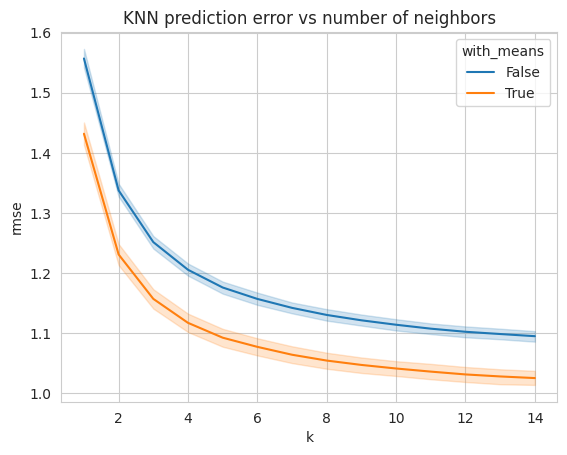

In [84]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

sns.lineplot(df, y='rmse', x='k', hue='with_means')
plt.title('KNN prediction error vs number of neighbors')

Выводы:
- чем больше соседей, тем меньше ошибка
- предсказание относительно среднего дает меньшюю ошибку

Примечание: на большем числе соседей не тестировал с целью сократить время вычислений

Text(0.5, 1.0, 'KNN prediction quality vs distance metric used')

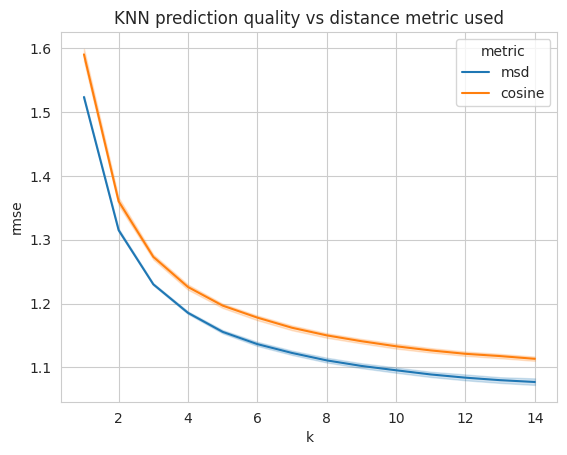

In [85]:
df_ = df[df.with_means == False]
sns.lineplot(df_, y='rmse', x='k', hue='metric')
plt.title('KNN prediction quality vs distance metric used')

Вывод:
- использование метрики MSD вместо косинусной уменьшает ошибку, это можно объяснить тем, что векторы пользователей имеют разные длины (векторные нормы) и геометрия пространства более хаотичная, чем поверхность единичной сферы (для которой косинус подошел бы идеально)

Text(0.5, 1.0, 'KNN calculation time vs number of neighbors and metric')

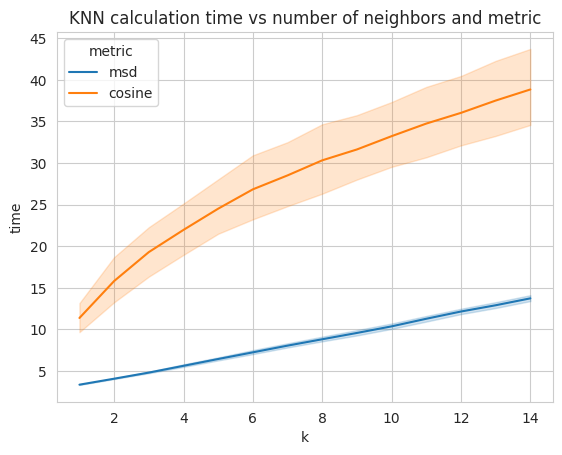

In [86]:
sns.lineplot(df, y='time', x='k', hue='metric')
plt.title('KNN calculation time vs number of neighbors and metric')

Выводы:
- чем больше соседей, тем дольше их нужно искать (очевидно)
- тот факт, что кривая времени, соответствующая косинусу, располагается значительно выше, вообще говоря связан с тем, что косинусная мера часто выдает в качестве соседей тех пользователей, у которых нет необходимой для предсказания оценки, и перебор ближайших соседей занимает больше времени
- т.е. MSD эффективно выделяет не просто ближайших соседей, а соседей с нужным числом общих товаров

Text(0.5, 1.0, 'KNN calculation time vs number of common items required and metric')

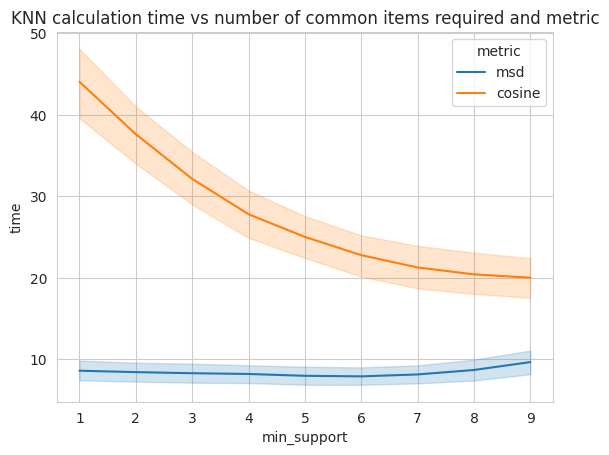

In [87]:
df_ = df[df.k == 10]
sns.lineplot(df, y='time', x='min_support', hue='metric')
plt.title('KNN calculation time vs number of common items required and metric')

Выводы:
- подтверждена гипотеза о том, что косинус выделяет объекты, у которых недостаточно общих товаров для оценки, что становится причиной долгого поиска соседей (это иллюстрируется резким спадом времени при ручной фильтрации соседей с недостаточным числом общих товаров)

Text(0.5, 1.0, 'KNN prediction quality vs number of common items required and metric')

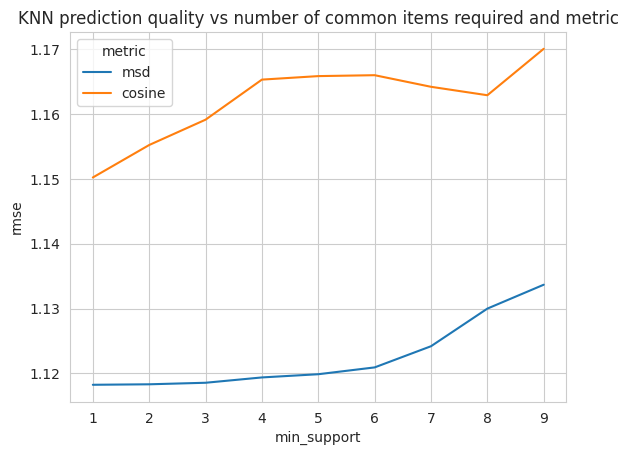

In [88]:
df_ = df[(df.k == 7) & (df.with_means == False)]
sns.lineplot(df_, y='rmse', x='min_support', hue='metric')
plt.title('KNN prediction quality vs number of common items required and metric')

Выводы:
- с ростом параметра `min_support` качество предсказания ухудшается. Это объяснимо тем, что уменьшается число соседей, с помощью которых совершается предсказание, а (как было выяснено выше) чем меньше соседей, тем хуже качество.

### SVD SGD

In [89]:
df = pd.DataFrame(res_1)
res_1.keys()

dict_keys(['time', 'rmse', 'n_factors', 'lr', 'reg'])

Text(0.5, 1.0, 'SVD SGD prediction quality vs number of factors and learning rate')

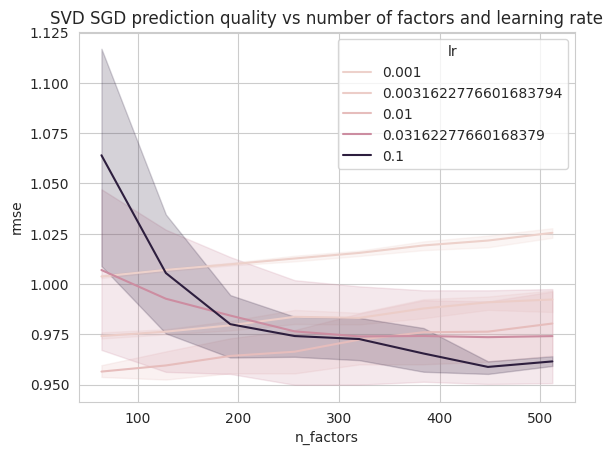

In [90]:
sns.lineplot(df, y='rmse', x='n_factors', hue='lr')
plt.title('SVD SGD prediction quality vs number of factors and learning rate')

Выводы:
- для малого lr (до 0.01 включительно) увеличение числа факторов ведет к увеличение ошибки
- для остальных lr увеличение числа факторов, наоборот, ведет к уменьшению ошибки

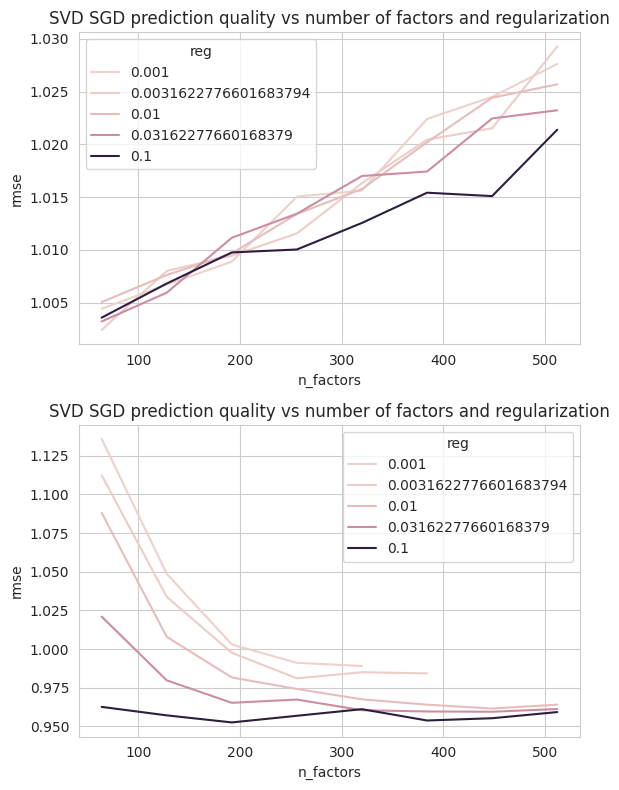

In [91]:
fig, ax = plt.subplots(2, 1, figsize=(6,8))

sns.lineplot(df[df.lr == 0.001], y='rmse', x='n_factors', hue='reg', ax=ax[0])
ax[0].set_title('SVD SGD prediction quality vs number of factors and regularization')

sns.lineplot(df[df.lr == 0.1], y='rmse', x='n_factors', hue='reg', ax=ax[1])
ax[1].set_title('SVD SGD prediction quality vs number of factors and regularization')

plt.tight_layout()

Выводы:
- для всех lr регуляризация уменьшает ошибку

Text(0.5, 1.0, 'SVD SGD training time vs number of factors')

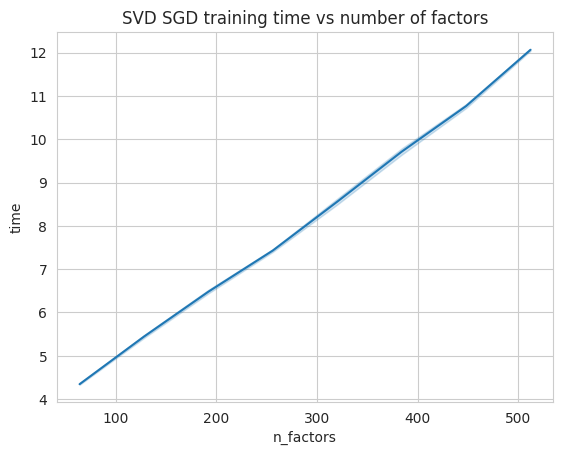

In [92]:
sns.lineplot(df, y='time', x='n_factors')
plt.title('SVD SGD training time vs number of factors')

Выводы:
- линейная зависимость времени от числа факторов

Примечание: возможно рассмотренный диапазон числа факторов недостаточно широк, чтобы выявить более сложную зависимость, поэтому ниже эксперимент повторен.

In [65]:
from colfil import svd

param_grid = dict(
    n_factors = range(50, 1551, 100),
)

def rmse(df):
    return ((df.rating - df.pred_rating) ** 2).mean() ** 0.5

res_1_extra = my_grid_search(
    param_grid,
    const_parameters=dict(
        df_train=df_train, df_test=df_test,
        lr=0.01,
        reg=0.1
    ),
    func=svd,
    rmse_callable=rmse,
    verbose=True
)

{'n_factors': 50}
{'n_factors': 150}
{'n_factors': 250}
{'n_factors': 350}
{'n_factors': 450}
{'n_factors': 550}
{'n_factors': 650}
{'n_factors': 750}
{'n_factors': 850}
{'n_factors': 950}
{'n_factors': 1050}
{'n_factors': 1150}
{'n_factors': 1250}
{'n_factors': 1350}
{'n_factors': 1450}
{'n_factors': 1550}


Text(0.5, 1.0, 'SVD SGD training time vs number of factors')

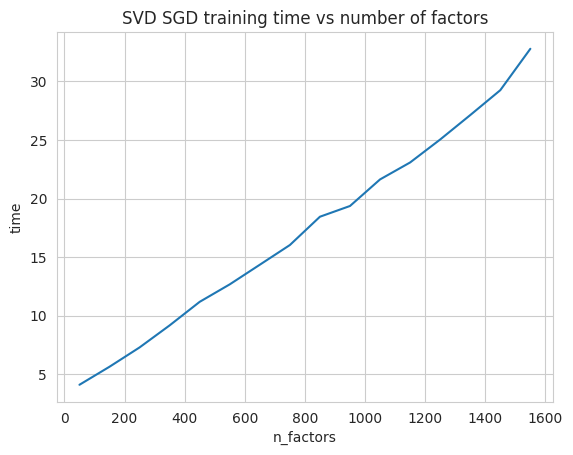

In [66]:
df = pd.DataFrame(res_1_extra)
sns.lineplot(df, y='time', x='n_factors')
plt.title('SVD SGD training time vs number of factors')

### SVD ALS

In [93]:
df = pd.DataFrame(res_2)
res_2.keys()

dict_keys(['time', 'rmse', 'n_factors', 'reg'])

Text(0.5, 1.0, 'SVD ALS prediction quality vs number of factors and regularization')

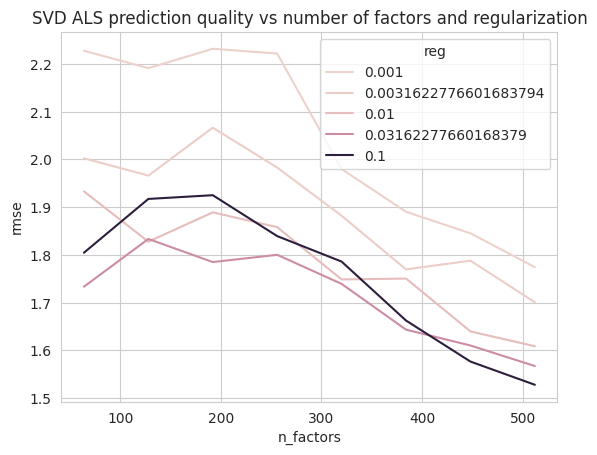

In [94]:
sns.lineplot(df, y='rmse', x='n_factors', hue='reg')
plt.title('SVD ALS prediction quality vs number of factors and regularization')

Выводы:
- регуляризация уменьшает ошибку
- чем больше факторов, тем меньше ошибка

Text(0.5, 1.0, 'SVD ALS training time vs number of factors')

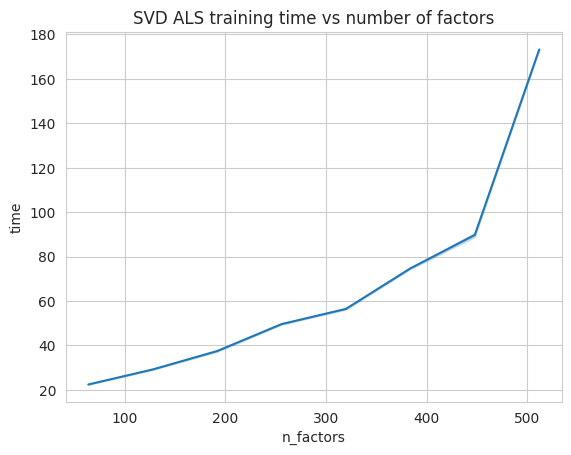

In [95]:
sns.lineplot(df, y='time', x='n_factors')
plt.title('SVD ALS training time vs number of factors')

Выводы:
- степенная зависимость, это можно объяснить тем, что для совершения одного шага необходимо решить систему уравнений с матрицей `n_factors * n_factors`

### SVD++

In [96]:
df = pd.DataFrame(res_3)
res_3.keys()

dict_keys(['time', 'rmse', 'n_factors', 'lr', 'reg'])

Text(0.5, 1.0, 'SVD++ prediction quality vs number of factors and learning rate')

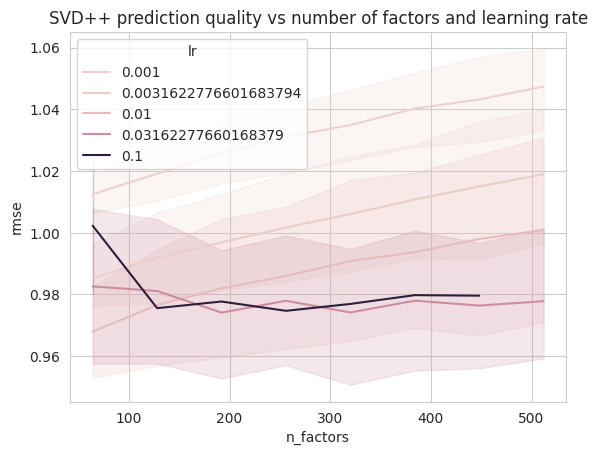

In [97]:
sns.lineplot(df, y='rmse', x='n_factors', hue='lr')
plt.title('SVD++ prediction quality vs number of factors and learning rate')

Выводы:
- такие же, что и для SVD SGD (видимо потому что одинаковый метод оптимизации и в целом модели очеь похожи)

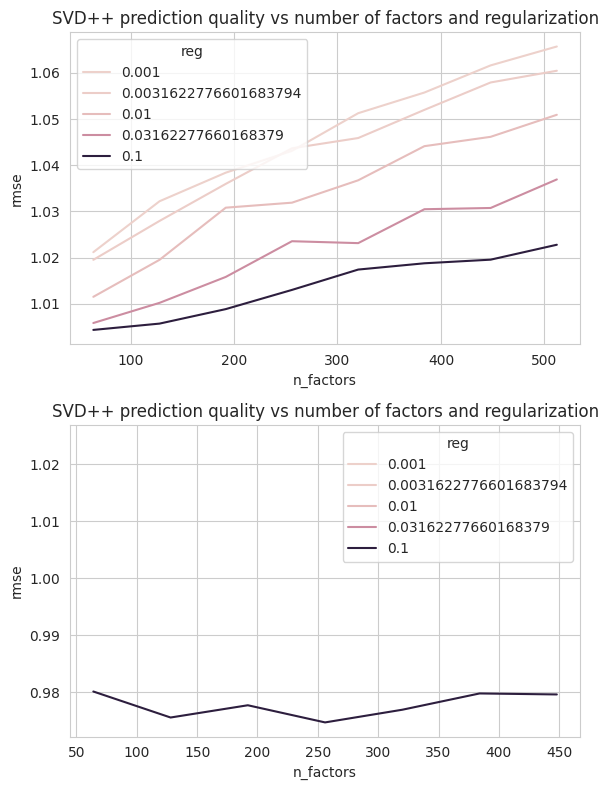

In [98]:
fig, ax = plt.subplots(2, 1, figsize=(6,8))

sns.lineplot(df[df.lr == 0.001], y='rmse', x='n_factors', hue='reg', ax=ax[0])
ax[0].set_title('SVD++ prediction quality vs number of factors and regularization')

sns.lineplot(df[df.lr == 0.1], y='rmse', x='n_factors', hue='reg', ax=ax[1])
ax[1].set_title('SVD++ prediction quality vs number of factors and regularization')

plt.tight_layout()

In [99]:
df[df.lr == 0.1]

,time,rmse,n_factors,lr,reg
20,56.755706,NaN,64,0.1,0.001000
21,57.003371,NaN,64,0.1,0.003162
22,56.962377,NaN,64,0.1,0.010000
23,57.191073,1.024422,64,0.1,0.031623
24,56.363051,0.980130,64,0.1,0.100000
45,74.437310,NaN,128,0.1,0.001000
46,75.185856,NaN,128,0.1,0.003162
47,75.238780,NaN,128,0.1,0.010000
48,74.096230,NaN,128,0.1,0.031623
49,75.107627,0.975567,128,0.1,0.100000


Выводы:
- большой lr ведет к тому, что оптимизация не сходится
- регуляризация уменьшает ошибку и помогает оптимизации сойтись

Text(0.5, 1.0, 'SVD++ training time vs number of factors')

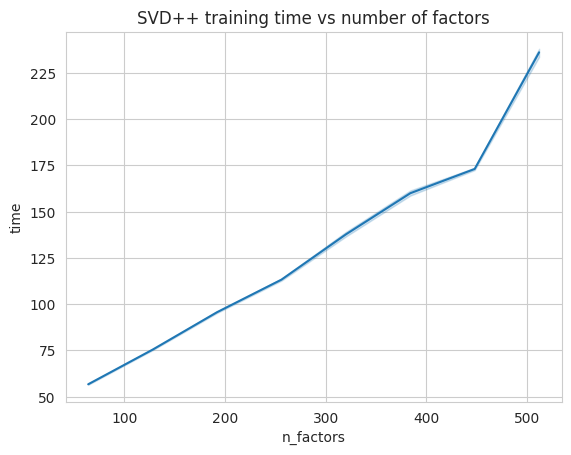

In [100]:
sns.lineplot(df, y='time', x='n_factors')
plt.title('SVD++ training time vs number of factors')

Выводы:
- нужно повторить эксперимент

In [67]:
from colfil import svdpp

param_grid = dict(
    n_factors = range(50, 1551, 300),
)

def rmse(df):
    return ((df.rating - df.pred_rating) ** 2).mean() ** 0.5

res_3_extra = my_grid_search(
    param_grid,
    const_parameters=dict(
        df_train=df_train, df_test=df_test,
        lr=0.01,
        reg=0.1
    ),
    func=svdpp,
    rmse_callable=rmse,
    verbose=True
)

{'n_factors': 50}
{'n_factors': 350}
{'n_factors': 650}
{'n_factors': 950}
{'n_factors': 1250}
{'n_factors': 1550}


Text(0.5, 1.0, 'SVD++ training time vs number of factors')

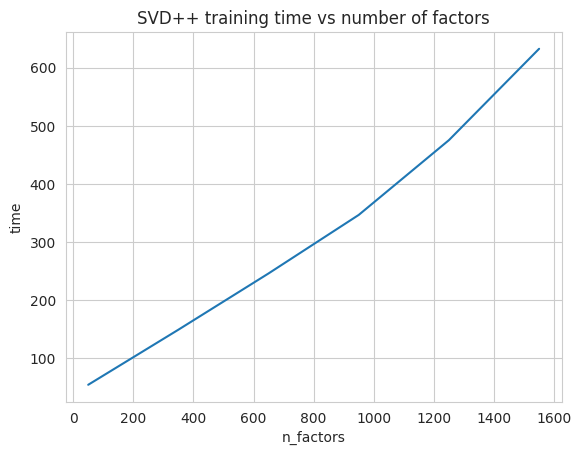

In [68]:
df = pd.DataFrame(res_3_extra)

sns.lineplot(df, y='time', x='n_factors')
plt.title('SVD++ training time vs number of factors')

## Сравнение всех

In [101]:
i_knn_best = np.argmin(res['rmse'])
i_svd_sgd_best = np.nanargmin(res_1['rmse'])
i_svd_als_best = np.nanargmin(res_2['rmse'])
i_svd_pp_best = np.nanargmin(res_3['rmse'])

In [102]:
print('knn best:')
for name, val in res.items():
    print(name, val[i_knn_best], end=', ')

knn best:
time 14.052018880844116, rmse 0.9959904617975984, metric msd, min_support 1, k 14, with_means True, 

In [103]:
print('svd sgd best:')
for name, val in res_1.items():
    print(name, val[i_svd_sgd_best], end=', ')

svd sgd best:
time 7.492040634155273, rmse 0.933738666144008, n_factors 256, lr 0.03162277660168379, reg 0.1, 

In [104]:
print('svd als best:')
for name, val in res_2.items():
    print(name, val[i_svd_als_best], end=', ')

svd als best:
time 173.01630663871765, rmse 1.527940649112222, n_factors 512, reg 0.1, 

In [105]:
print('svd pp best:')
for name, val in res_3.items():
    print(name, val[i_svd_pp_best], end=', ')

svd pp best:
time 57.14359450340271, rmse 0.9380308208595513, n_factors 64, lr 0.03162277660168379, reg 0.1, 

SVD SGD топ1 по качеству (приятный бонус: и по времени)